In [1]:
!git clone https://github.com/salesforce/PCL.git
%cd PCL



Cloning into 'PCL'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 160 (delta 18), reused 12 (delta 12), pack-reused 134 (from 2)
Receiving objects: 100% (160/160), 196.36 KiB | 810.00 KiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/PCL


In [2]:
!pip install torch torchvision
!pip install numpy tqdm pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  #GPU name

True
Tesla T4


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATASET_PATH = "/content/drive/My Drive/dataset_cropped"

In [6]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 27.2 MB/s eta 0:00:00


In [7]:
import sys
sys.path.insert(0, "/content/PCL")  # force project path

from pcl import builder
print("Builder path:", builder.__file__)
print("Has MoCo:", hasattr(builder, "MoCo"))


Builder path: /content/PCL/pcl/builder.py
Has MoCo: True


In [8]:
import os, sys
sys.path.append('/content/PCL')

from pcl import builder
print(" Import worked!")

import sys
sys.path.insert(0, "/content/PCL")


 Import worked!


In [ ]:
%reset -f

In [ ]:
import importlib
import pcl.builder as builder

importlib.reload(builder)  # Force reload builder.py


<module 'pcl.builder' from '/content/PCL/pcl/builder.py'>

In [8]:
import torch
import torch.nn as nn
from torchvision import models

# --- MoCo class for MobileNetV2 only ---
class MoCo(nn.Module):
    def __init__(self, base_encoder, dim=128, r=16384, m=0.999, T=0.1, mlp=False):
        super().__init__()
        self.r = r
        self.m = m
        self.T = T
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Encoders
        self.encoder_q = base_encoder(num_classes=dim).to(self.device)
        self.encoder_k = base_encoder(num_classes=dim).to(self.device)

        # Replace MobileNet classifier head
        if isinstance(self.encoder_q.classifier, nn.Sequential):
            in_features = self.encoder_q.classifier[-1].in_features
            if mlp:
                self.encoder_q.classifier = nn.Sequential(
                    nn.Linear(in_features, in_features), nn.ReLU(), nn.Linear(in_features, dim)
                )
                self.encoder_k.classifier = nn.Sequential(
                    nn.Linear(in_features, in_features), nn.ReLU(), nn.Linear(in_features, dim)
                )
            else:
                self.encoder_q.classifier[-1] = nn.Linear(in_features, dim)
                self.encoder_k.classifier[-1] = nn.Linear(in_features, dim)

        # Copy weights from query to key
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        self.register_buffer("queue", torch.randn(dim, r))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.r
        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k=None, is_eval=False):
        im_q = im_q.to(self.device)
        if im_k is not None:
            im_k = im_k.to(self.device)

        q = nn.functional.normalize(self.encoder_q(im_q), dim=1)

        if is_eval:
            return nn.functional.normalize(self.encoder_k(im_q), dim=1)

        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = nn.functional.normalize(self.encoder_k(im_k), dim=1)
            self._dequeue_and_enqueue(k)

        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach().to(self.device)])
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        return logits, labels, None, None

# --- Instantiate MoCo with MobileNetV2 ---
mobilenet = models.mobilenet_v2
model = MoCo(mobilenet, dim=128, mlp=False)
print("MoCo model with MobileNetV2 created successfully!")


MoCo model with MobileNetV2 created successfully!


In [10]:
import sys
sys.path.append("/content/PCL")  # ensure pcl module is found
import pcl.builder as builder
print(hasattr(builder, "MoCo"))  # should print True


True


In [ ]:
from torchvision import models
mobilenet = models.mobilenet_v2
model = builder.MoCo(mobilenet, dim=128, mlp=False)


In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
import pcl.builder  # your builder.py containing MoCo

# Define architecture
arch = "mobilenet_v2"

# Create the MoCo model
model = pcl.builder.MoCo(
    base_encoder=models.__dict__[arch],
    dim=128,
    r=16384,
    m=0.999,
    T=0.2,
    mlp=False
)

print(model)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MoCo(
  (encoder_q): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1),

In [ ]:
import importlib
import pcl.builder as builder

importlib.reload(builder)  # forces Python to re-read builder.py

# now MoCo should be available
model = builder.MoCo(
    base_encoder=models.mobilenet_v2,
    dim=128,
    r=16384,
    m=0.999,
    T=0.2,
    mlp=False
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
from pcl.builder import MoCo
print("MoCo loaded:", MoCo)


MoCo loaded: <class 'pcl.builder.MoCo'>


In [12]:
import sys, importlib

# Make sure PCL is first in the Python path
sys.path.insert(0, "/content/PCL")

# Force reload of builder.py
import pcl.builder
importlib.reload(pcl.builder)

# Now test
print("MoCo available?", hasattr(pcl.builder, "MoCo"))

# Try importing directly
from pcl.builder import MoCo
print("MoCo loaded successfully:", MoCo)


MoCo available? True
MoCo loaded successfully: <class 'pcl.builder.MoCo'>


In [ ]:
import sys
sys.path.insert(0, "/content/PCL")

from pcl import builder
print("MoCo available?", hasattr(builder, "MoCo"))


MoCo available? True


In [ ]:
import pcl.builder as builder
print("Loaded from:", builder.__file__)
print("Has MoCo:", hasattr(builder, "MoCo"))


Loaded from: /content/PCL/pcl/builder.py
Has MoCo: True


In [ ]:
!python3 /content/PCL/main_pcl.py \
  "/content/drive/My Drive/dataset_cropped" \
  --arch mobilenet_v2 \
  --epochs 300 \
  --batch-size 32 \
  --lr 0.001 \
  --temperature 0.2 \
  --num-cluster 3

DEBUG (main_pcl): using builder from /content/PCL/pcl/builder.py
DEBUG (main_pcl): MoCo available? True
=> creating model 'mobilenet_v2'
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
MoCo(
  (encoder_q): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
      

In [11]:
# --- Install dependencies ---
!pip install faiss-cpu umap-learn scikit-learn matplotlib


Using checkpoint: /content/PCL/experiment_pcl/checkpoint_0299.pth.tar


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


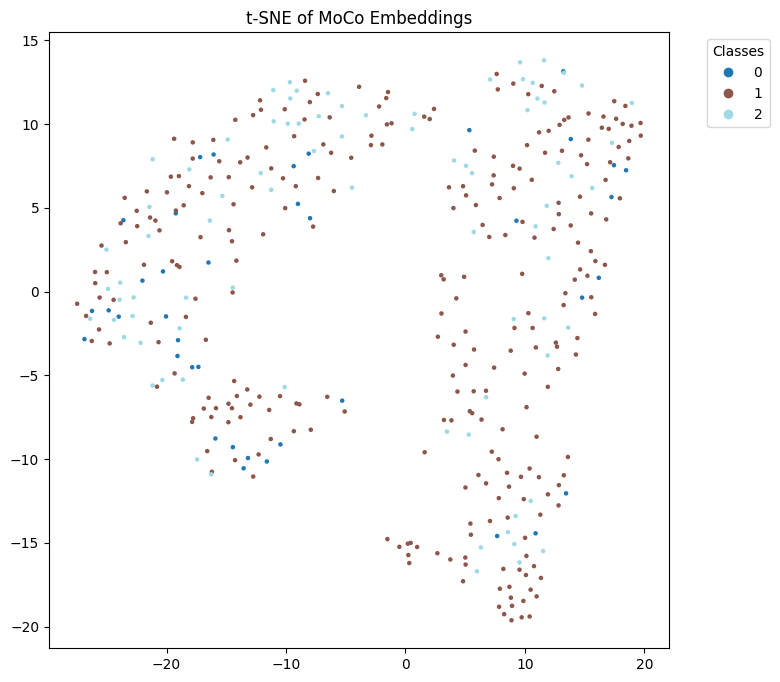

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


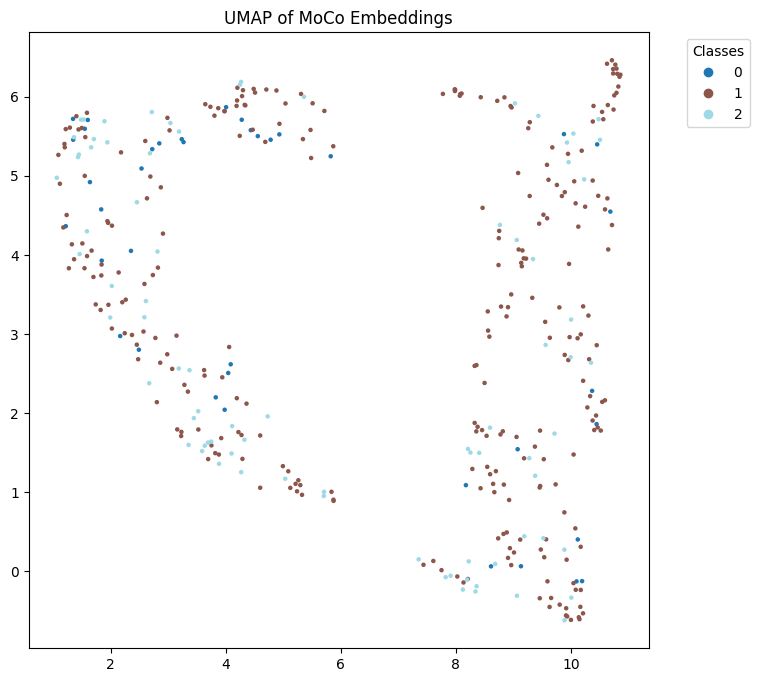

NMI: 0.2360
ARI: 0.0000
Silhouette Score: -0.0235


In [20]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score
import numpy as np
import umap
import glob
from pcl import builder
import torchvision.models as models

# --- latest checkpoint ---
checkpoints = sorted(glob.glob("/content/PCL/experiment_pcl/checkpoint_*.pth.tar"))
checkpoint_path = checkpoints[-1]  # latest checkpoint
print("Using checkpoint:", checkpoint_path)

# --- Manually set args used in training ---
arch = "mobilenet_v2"
low_dim = 128
pcl_r = 4
moco_m = 0.999
temperature = 0.2
mlp = True

arch = "mobilenet_v2"
model = builder.MoCo(
    models.__dict__[arch],
    dim=128,
    r=4,
    m=0.999,
    T=0.1,
    mlp=True
)

# --- Load checkpoint but remove queue ---
ckpt = torch.load(checkpoint_path, map_location="cpu")
state_dict = ckpt['state_dict']
state_dict = {k: v for k, v in state_dict.items() if not k.startswith('queue')}
model.load_state_dict(state_dict, strict=False)
model.eval().cuda()

# --- Dataset & DataLoader ---
data_path = "/content/drive/MyDrive/dataset_cropped"
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_path, transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# --- Feature extraction ---
all_features = []
all_labels = []

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.cuda(non_blocking=True)
        feats = model.encoder_q(imgs)  # MoCo encoder
        feats = torch.nn.functional.normalize(feats, dim=1)
        all_features.append(feats.cpu())
        all_labels.append(labels)

all_features = torch.cat(all_features, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# --- t-SNE Visualization ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embeds = tsne.fit_transform(all_features)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1], c=all_labels, cmap="tab20", s=5)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE of MoCo Embeddings")
plt.show()

# --- UMAP Visualization ---
umap_embeds = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(all_features)
plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_embeds[:, 0], umap_embeds[:, 1], c=all_labels, cmap="tab20", s=5)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP of MoCo Embeddings")
plt.show()

# --- Clustering Metrics ---
nmi = normalized_mutual_info_score(all_labels, np.argmax(all_features @ all_features.T, axis=1))
ari = adjusted_rand_score(all_labels, np.argmax(all_features @ all_features.T, axis=1))
sil = silhouette_score(all_features, all_labels)

print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"Silhouette Score: {sil:.4f}")


In [21]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# --- Paths ---
train_dir = "/content/drive/My Drive/dataset_cropped/train"
test_dir  = "/content/drive/My Drive/dataset_cropped/test"

# --- Data transforms ---
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Load datasets ---
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


Train size: 279
Test size: 39


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [22]:
# --- Feature extraction ---
def extract_features(dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.cuda(non_blocking=True)
            feats = model.encoder_q(imgs)  # MoCo encoder
            feats = F.normalize(feats, dim=1)
            features.append(feats.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

train_features, train_labels = extract_features(train_loader)
test_features, test_labels   = extract_features(test_loader)


In [23]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Compute class centroids from training features ---
def compute_centroids(features, labels, num_classes):
    centroids = []
    for c in range(num_classes):
        mask = labels == c
        class_feats = features[mask]
        centroid = class_feats.mean(dim=0)
        centroids.append(centroid)
    return torch.stack(centroids)

num_classes = len(train_dataset.classes)
centroids = compute_centroids(train_features, train_labels, num_classes)
centroids = F.normalize(centroids, dim=1)  # normalize like features

# --- Predict test labels using nearest centroid ---
def predict_with_centroids(test_feats, centroids):
    sims = test_feats @ centroids.T  # cosine similarity
    preds = torch.argmax(sims, dim=1)
    return preds

pred_labels = predict_with_centroids(test_features, centroids)

# --- Metrics ---
y_true = test_labels.numpy()
y_pred = pred_labels.numpy()

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

# specificity per class
cm = confusion_matrix(y_true, y_pred)
specificity = []
for i in range(num_classes):
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    fp = cm[:,i].sum() - cm[i,i]
    specificity.append(tn / (tn + fp))
specificity = np.mean(specificity)

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)
print("Confusion Matrix:\n", cm)


Accuracy: 0.6153846153846154
Precision: 0.6363636363636364
Recall (Sensitivity): 0.6153846153846154
F1 Score: 0.5444444444444444
Specificity: 0.8076923076923078
Confusion Matrix:
 [[10  1  2]
 [ 1  1 11]
 [ 0  0 13]]
